In [107]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from bs4 import BeautifulSoup
import time
import pandas as pd

In [108]:
# Constants
SOURCE_COUNTRY = 'sin'
DEST_COUNTRY = 'mil'
FROM_DATE = '25-06-25'
END_DATE = '2025-06-04'
NUM_ADULTS = '1'
TRIP_TYPE = 'rt'

In [109]:
import shutil
chromedriver_path = shutil.which("chromedriver")
service = Service(chromedriver_path)
options = webdriver.ChromeOptions()
# options.add_argument("--headless") 


Reached the bottom. No more data to load.
<html data-ares-version="5.23.0" data-cargo="locale:en-SG,language:sg,currency:SGD,contextType:online,site:SG,group:Trip,country:SG" data-host-ip="10.152.54.8" data-idc="SGP-ALI" lang="en-SG" style="font-size:57.5px" translate="no">
 <head>
  <title>
   Flights from Singapore to Milan | Trip.com
  </title>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=5.0, minimum-scale=1.0, minimal-ui" name="viewport"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="Singapore to Milan, flights from Singapore to Milan, flight tickets from Singapore to Milan, cheap flights from Singapore to Milan, cheap flights, ticket prices, Trip.com" data-rh="true" name="keywords"/>
  <meta content="Browse flight times and tickets, save a maximum of 55% on flights booked on Trip.com from Singapore to Milan. Search cheap flight tickets from Singapore to Milan on Trip.com, and get great savings on Tri
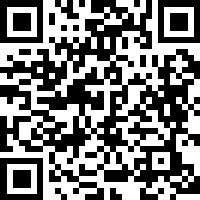

In [110]:
driver = webdriver.Chrome(service=service, options=options)
url = f'https://sg.trip.com/flights/showfarefirst?dcity={SOURCE_COUNTRY}&acity={DEST_COUNTRY}&ddate={FROM_DATE}&rdate={END_DATE}&triptype={TRIP_TYPE}&quantity={NUM_ADULTS}'
driver.get(url)

# Get all window handles
windows = driver.window_handles

# Switch to the newly opened window
driver.switch_to.window(windows[-1])  # Usually the last one is the new window

# Do stuff in the new window
print(driver.title)

# Optionally, switch back to the original window
driver.switch_to.window(windows[0])
SCROLL_PAUSE_TIME = 3

# Get initial scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait for new content to load
    time.sleep(SCROLL_PAUSE_TIME)

    # Check new scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")

    if new_height == last_height:
        print("Reached the bottom. No more data to load.")
        break

    last_height = new_height
wait = WebDriverWait(driver, 100)
wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, '[data-toast-title="All flight results loaded"]')))
time.sleep(30)
try:
    wait.until(
        EC.invisibility_of_element_located(
            (By.CSS_SELECTOR, ".list-placeholder-v2.list-placeholder-v2__loading")
        )
    )
except:
    print('not all results loaded')

# html_content = dynamic_element.get_attribute('outerHTML')

# Parse HTML with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Now you can use soup to find stuff inside the dynamic element
print(soup.prettify())


In [111]:
scraped_results = []
m_result_div = soup.find("div", class_ = "m-result-list")
flight_divs = m_result_div.find_all("div", attrs={"data-flight-id": True})

for flight_div in flight_divs:
    try:
        flight_info_output = {}
        flight_info_list_div = flight_div.find("div", class_="flight-info-list")
        airline_name_div = flight_info_list_div.find("div", class_ = "flight-info is-v2")
        airline_name = airline_name_div.get('aria-label')
        flight_info_output['airline_name'] = airline_name.strip()
        name_of_airline_div = flight_info_list_div.find("div", class_ = "flight-info-col col-1")
        date_and_time_of_flight_div = flight_info_list_div.find("div", class_ = "flight-info-col col-2")
        time_divs = date_and_time_of_flight_div.find_all("span", class_ = "time_cbcc")
        flight_info_output['departure_time'] = time_divs[0].get("data-testid")[14:]
        flight_info_output['arrival_time'] = time_divs[1].get("data-testid")[14:]
        terminal_divs = date_and_time_of_flight_div.find_all("span", class_ = "flight-info-stop__code_e162")
        flight_info_output['departure_terminal'] = terminal_divs[0].get_text(strip=True)
        flight_info_output['arrival_terminal'] = terminal_divs[1].get_text(strip=True)
        mode_of_transport_div = date_and_time_of_flight_div.find("span", class_ = "flight-info-stop__text_3ee2")
        flight_info_output['Way_Of_Travel'] = mode_of_transport_div.get('aria-label')
        travel_time_in_hours_div = date_and_time_of_flight_div.find("div", class_ = "flight-info-duration_576d")
        flight_info_output['Time in Hours'] = travel_time_in_hours_div.get_text(strip=True)
        trip_type_div = flight_div.find("div", class_="item-con-price__tag")
        flight_info_output['Trip_Type'] = trip_type_div.get_text(strip=True)

        price_div = flight_div.find("span", class_="ThemeColor8 f-20 o-price-flight_b825 no-cursor_1b76")
        flight_info_output['Price'] = '$' + price_div.get('data-price')

        scraped_results.append(flight_info_output)
    except Exception as e:
        continue
output_df = pd.DataFrame(scraped_results)
output_df = output_df.drop_duplicates()
output_df

,airline_name,departure_time,arrival_time,departure_terminal,arrival_terminal,Way_Of_Travel,Time in Hours,Trip_Type,Price
0,Singapore Airlines,25-06-05 23:30:00,25-06-06 06:30:00,SIN T3,MXP T1,Direct,13h,Return,$1540
2,"Etihad Airways ,Etihad Airways Transfer i...",25-06-05 21:10:00,25-06-06 18:40:00,SIN T2,MXP T1,13h 35m in Abu Dhabi,27h 30m,Return,$708
4,"Etihad Airways ,Etihad Airways Transfer i...",25-06-05 21:10:00,25-06-06 06:45:00,SIN T2,MXP T1,1h 40m in Abu Dhabi,15h 35m,Return,$805
6,"Emirates ,Emirates Transfer in Dubai 1h 40m",25-06-05 10:35:00,25-06-05 20:20:00,SIN T1,MXP T1,1h 40m in Dubai,15h 45m,Return,$845
8,"Emirates ,Emirates Transfer in Dubai 4h 40m",25-06-05 01:40:00,25-06-05 14:10:00,SIN T1,MXP T1,4h 40m in Dubai,18h 30m,Return,$845
10,"Emirates ,Emirates Transfer in Dubai 5h 20m",25-06-05 00:50:00,25-06-05 14:10:00,SIN T1,MXP T1,5h 20m in Dubai,19h 20m,Return,$845
12,"Emirates ,Emirates Transfer in Dubai 10h 40m",25-06-05 01:40:00,25-06-05 20:20:00,SIN T1,MXP T1,10h 40m in Dubai,24h 40m,Return,$845
14,"Emirates ,Emirates Transfer in Dubai 11h 20m",25-06-05 00:50:00,25-06-05 20:20:00,SIN T1,MXP T1,11h 20m in Dubai,25h 30m,Return,$845
16,"Emirates ,Emirates Transfer in Dubai 9h 15m",25-06-05 21:00:00,25-06-06 14:10:00,SIN T1,MXP T1,9h 15m in Dubai,23h 10m,Return,$945
18,"Emirates ,Emirates Transfer in Dubai 15h 15m",25-06-05 21:00:00,25-06-06 20:20:00,SIN T1,MXP T1,15h 15m in Dubai,29h 20m,Return,$945
